## Exercise

* Download the swimming data from https://en.wikipedia.org/wiki/List_of_world_records_in_swimming
* Combine the frames with the records and clean up the data
* Give a ranking of the swimming speed over different disciplines
* Save the clean data in a file called `swimming_records.feather`

## Analysis

* Give an estimate of how much time a turning point adds to swimming a distance
* Give an estimate of how much time a start adds to adds to swimming 

In [1]:
import pandas as pd

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [94]:
url = "https://en.wikipedia.org/wiki/List_of_world_records_in_swimming"

tables = pd.read_html(url, header = 0, encoding='utf-8')
tables[0].head(5)

,Event,Time,Unnamed: 2,Name,Nationality,Date,Meet,Location,Ref
0,01 ! 50 m freestyle,20.91,NaN,"Cielo, CésarCésar Cielo",Brazil,18 December 2009,Brazilian Championships,"Brazil, São Paulo ! São Paulo, Brazil",[9][10]
1,02 ! 100 m freestyle,46.91,NaN,"Cielo, CésarCésar Cielo",Brazil,30 July 2009,World Championships,"Italy, Rome ! Rome, Italy",[11][12]
2,03 ! 200 m freestyle,1:42.00,NaN,"Biedermann, PaulPaul Biedermann",Germany,28 July 2009,World Championships,"Italy, Rome ! Rome, Italy",[13][14]
3,04 ! 400 m freestyle,3:40.07,NaN,"Biedermann, PaulPaul Biedermann",Germany,26 July 2009,World Championships,"Italy, Rome ! Rome, Italy",[15][16]
4,05 ! 800 m freestyle,7:32.12,NaN,Zhang Lin,China,29 July 2009,World Championships,"Italy, Rome ! Rome, Italy",[17][18]


In [93]:
category = "men", "women", "mixed", "men", "women", "mixed"
course = "long", "long", "long", "short", "short", "short"

record_tables = [t for t in tables if "Event" in t.columns]
len(record_tables)

8

In [152]:
raw = pd.concat([t.assign(category = c, course = i) for t, c, i in zip(record_tables, category, course)]).reset_index(drop=True)
raw.sample(5)

,Event,Time,Unnamed: 2,Name,Nationality,Date,Meet,Location,Ref,category,course
82,15 ! 200 m butterfly,1:59.61,NaN,"Belmonte Garcia, MireiaMireia Belmonte Garcia",Spain,3 December 2014,World Championships,"Qatar, Doha ! Doha, Qatar",[108],women,short
48,07 ! 50 m backstroke,22.22,NaN,"Manaudou, FlorentFlorent Manaudou",France,6 December 2014,World Championships,"Qatar, Doha ! Doha, Qatar",[78],men,short
69,04 ! 400 m freestyle,3:54.52,NaN,"Belmonte García, MireiaMireia Belmonte García",Spain,11 August 2013,World Cup,"Germany, Berlin ! Berlin, Germany",[96],women,short
81,14 ! 100 m butterfly,54.61,NaN,"Sjöström, SarahSarah Sjöström",Sweden,7 December 2014,World Championships,"Qatar, Doha ! Doha, Qatar",[107],women,short
14,15 ! 200 m butterfly,1:51.51,NaN,"Phelps, MichaelMichael Phelps",United States,29 July 2009,World Championships,"Italy, Rome ! Rome, Italy",[32][33],men,long


In [153]:
raw.shape

(95, 11)

In [154]:
raw.rename(columns = lambda x: x.lower().replace(' ', ''), inplace = True)
raw.drop(['ref', 'unnamed:2'], axis = 1, inplace = True, errors='ignore')
raw.head(2)

,event,time,name,nationality,date,meet,location,category,course
0,01 ! 50 m freestyle,20.91,"Cielo, CésarCésar Cielo",Brazil,18 December 2009,Brazilian Championships,"Brazil, São Paulo ! São Paulo, Brazil",men,long
1,02 ! 100 m freestyle,46.91,"Cielo, CésarCésar Cielo",Brazil,30 July 2009,World Championships,"Italy, Rome ! Rome, Italy",men,long


## Parsing events with regexes

* Non-breaking spaces
* Just pasted the weird `x` character

In [155]:
raw.event.values[0], raw.event.values[25], raw.event.values[17]

('01 ! 50\xa0m freestyle',
 '06 ! 1500\xa0m freestyle',
 '18 ! 4×100\xa0m freestyle relay')

In [156]:
parsed_events = raw.event.str.replace(u'\xa0', ' ').str.extract('[\d\.]+ ! (?:(?P<team_size>4)×)?(?P<distance>\d{2,4}) m (?P<swimstyle>[a-z ]+)', expand = True)
parsed_events[parsed_events.swimstyle.isnull()]

,team_size,distance,swimstyle


In [157]:
parsed_events.swimstyle = parsed_events.swimstyle.astype('category')
parsed_events["team_size"] = parsed_events.team_size.fillna(1).astype(int)
parsed_events.distance = parsed_events.distance.astype(int) * parsed_events.team_size

parsed_events.assign(original = raw.event).sample(5)

,team_size,distance,swimstyle,original
38,4,800,freestyle relay,19 ! 4×200 m freestyle relay
91,4,200,medley relay,22.2 ! 4×50 m medley relay
73,1,100,backstroke,08 ! 100 m backstroke
76,1,100,breaststroke,11.1 ! 100 m breaststroke
89,4,800,freestyle relay,21 ! 4×200 m freestyle relay


In [158]:
## Parsing the times

In [159]:
parsed_times = raw.time.str.extract("(?P<m>\d{1,2})?:?(?P<s>\d{2})\.(?P<ms>\d{2})", expand = True)
time_seconds = times.m.astype(float).fillna(0) * 60 + times.s.astype(float) + times.ms.astype(float) / 100
raw.assign(time_seconds = time_seconds)[["event", "time_seconds"]].sample(10)

,event,time_seconds
12,13 ! 50 m butterfly,22.43
62,20 ! 4×100 m freestyle relay,183.30
57,16 ! 100 m individual medley,50.30
1,02 ! 100 m freestyle,46.91
55,14 ! 100 m butterfly,48.08
53,12 ! 200 m breaststroke,120.44
5,06 ! 1500 m freestyle,871.02
46,05 ! 800 m freestyle,443.42
56,15 ! 200 m butterfly,108.56
35,16 ! 200 m individual medley,126.12


## Splitting doubled name and location

* Explicit vs. implicit

In [160]:
raw.name.values[0], raw.name.values[10]

('Cielo, CésarCésar Cielo', 'Peaty, AdamAdam Peaty')

In [161]:
parsed_names = raw.name.str.extract(r"(?P<last_name>[\w ]+), (?P<first_name>[\S ]+)\2 \1", expand = True)
parsed_names_simple = raw.name.str.extract(r"^(?P<last_name>[\w]+) (?P<first_name>[\w ]+)$", expand = True)

q = parsed_names.first_name.isnull() & parsed_names_simple.first_name.notnull()
parsed_names.loc[q] = parsed_names_simple.loc[q]

parsed_names.assign(original = raw.name).sample(10)

,last_name,first_name,original
84,Hosszú,Katinka,"Hosszú, KatinkaKatinka Hosszú"
78,Atkinson,Alia,"Atkinson, AliaAlia Atkinson"
32,Sjöström,Sarah,"Sjöström, SarahSarah Sjöström"
46,Hackett,Grant,"Hackett, GrantGrant Hackett"
18,NaN,NaN,(1:44.49) Michael Phelps (1:44.13) Ricky Bere...
5,Sun,Yang,Sun Yang
79,Soni,Rebecca,"Soni, RebeccaRebecca Soni"
70,Belmonte García,Mireia,"Belmonte García, MireiaMireia Belmonte García"
65,NaN,NaN,(49.63) Stanislav Donets (56.43) Sergey Geybe...
49,Kolesnikov,Kliment,"Kolesnikov, KlimentKliment Kolesnikov"


In [162]:
raw.location.values[0], raw.location.values[17]

('Brazil, São Paulo ! São Paulo, Brazil', 'China, Beijing ! Beijing, China')

In [163]:
parsed_locations = raw.location.str.extract(r'(?P<country>[\w ]+), (?P<city>[\w ]+) ! \2, \1', expand = True)
parsed_locations.assign(original = raw.location).sample(5)

,country,city,original
39,Hungary,Budapest,"Hungary, Budapest ! Budapest, Hungary"
22,Italy,Rome,"Italy, Rome ! Rome, Italy"
10,Brazil,Rio de Janeiro,"Brazil, Rio de Janeiro ! Rio de Janeiro, Brazil"
16,China,Beijing,"China, Beijing ! Beijing, China"
42,Qatar,Doha,"Qatar, Doha ! Doha, Qatar"


In [164]:
parsed_locations.country = parsed_locations.country.astype('category')
parsed_locations.city = parsed_locations.city.astype('category')
parsed_locations[parsed_locations.country.isnull()]

,country,city


In [166]:
## All together

events = parsed_events.join(
    time_seconds.rename("time")
).join(
    pd.to_datetime(raw.date)
).join(parsed_locations).join(parsed_names).join(
    raw[["course", "category", "nationality", "meet"]].apply(lambda x: x.astype('category'))
)

view = events.sample(10)
view

,team_size,distance,swimstyle,time,date,country,city,last_name,first_name,course,category,nationality,meet
32,1,50,butterfly,24.43,2014-07-05,Sweden,Borås,Sjöström,Sarah,long,women,Sweden,Swedish Championships
15,1,200,individual medley,114.00,2011-07-28,China,Shanghai,Lochte,Ryan,long,men,United States,World Championships
33,1,100,butterfly,55.48,2016-08-07,Brazil,Rio de Janeiro,Sjöström,Sarah,long,women,Sweden,Olympic Games
27,1,100,backstroke,58.10,2017-07-25,Hungary,Budapest,Masse,Kylie,long,women,Canada,World Championships
46,1,800,freestyle,443.42,2008-07-20,Australia,Melbourne,Hackett,Grant,short,men,Australia,Victoria Championships
1,1,100,freestyle,46.91,2009-07-30,Italy,Rome,Cielo,César,long,men,Brazil,World Championships
68,1,200,freestyle,110.43,2017-08-12,Netherlands,Eindhoven,Sjöström,Sarah,short,women,Sweden,World Cup
35,1,200,individual medley,126.12,2015-08-03,Russia,Kazan,Hosszú,Katinka,long,women,Hungary,World Championships
42,1,50,freestyle,20.26,2014-12-05,Qatar,Doha,Manaudou,Florent,short,men,France,World Championships
88,4,400,freestyle relay,206.53,2014-12-05,Qatar,Doha,NaN,NaN,short,women,Netherlands,World Championships


In [167]:
events.dtypes

team_size               int64
distance                int64
swimstyle            category
time                  float64
date           datetime64[ns]
country              category
city                 category
last_name              object
first_name             object
course               category
category             category
nationality          category
meet                 category
dtype: object

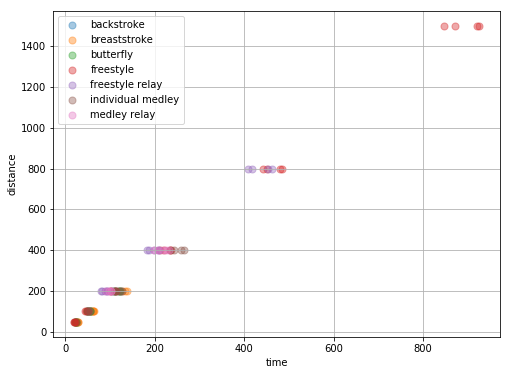

In [208]:
import seaborn as sns

fig = plt.figure(figsize = (8, 6))
ax = fig.subplots(1)
pal = sns.color_palette()

for i, (st, frame) in enumerate(events.groupby(["swimstyle"])):
    frame.plot.scatter(x = 'time', y = 'distance', label = st, ax = ax, color = pal[i], s = 50, alpha = .4);
    
ax.grid(True);

In [209]:
events.to_feather("../project/data/clean/swimming_records.feather")

In [210]:
events["speed"] = events.distance / events.time
events.sort_values('speed', ascending = False).head()

,team_size,distance,swimstyle,time,date,country,city,last_name,first_name,course,category,nationality,meet,speed
61,4,200,freestyle relay,80.77,2008-12-14,Croatia,Rijeka,NaN,NaN,short,men,France,European Championships,2.476167
42,1,50,freestyle,20.26,2014-12-05,Qatar,Doha,Manaudou,Florent,short,men,France,World Championships,2.467917
60,4,200,freestyle relay,82.60,2014-12-06,Qatar,Doha,NaN,NaN,short,men,Russia,World Championships,2.421308
0,1,50,freestyle,20.91,2009-12-18,Brazil,São Paulo,Cielo,César,long,men,Brazil,Brazilian Championships,2.391200
54,1,50,butterfly,21.80,2009-11-14,Germany,Berlin,Deibler,Steffen,short,men,Germany,World Cup,2.293578


In [211]:
events.sort_values('speed', ascending = False).tail()

,team_size,distance,swimstyle,time,date,country,city,last_name,first_name,course,category,nationality,meet,speed
30,1,100,breaststroke,64.13,2017-07-25,Hungary,Budapest,King,Lilly,long,women,United States,World Championships,1.559333
85,1,400,individual medley,258.94,2017-08-12,Netherlands,Eindhoven,Belmonte Garcia,Mireia,short,women,Spain,World Cup,1.544759
36,1,400,individual medley,266.36,2016-08-06,Brazil,Rio de Janeiro,Hosszú,Katinka,long,women,Hungary,Olympic Games,1.501727
79,1,200,breaststroke,134.57,2009-12-18,United Kingdom,Manchester,Soni,Rebecca,short,women,United States,Duel in the Pool,1.486215
31,1,200,breaststroke,139.11,2013-08-01,Spain,Barcelona,Pedersen,Rikke Møller,long,women,Denmark,World Championships,1.437711


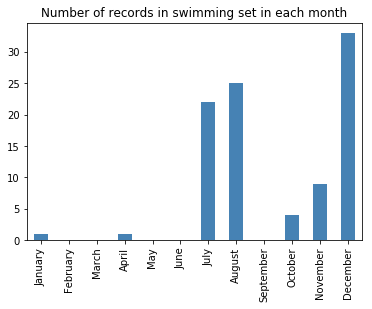

In [291]:
import calendar
month_names = [calendar.month_name[i] for i in range(1, 13)]

events.date.dt.strftime("%B").value_counts().reindex(month_names).plot.bar(color = "steelblue")
plt.title("Number of records in swimming set in each month");

* Give an estimate of how much time a turning point adds to swimming a distance
* Give an estimate of how much time a start adds to adds to swimming 

In [340]:
df = events.loc[events.team_size == 1, ["distance", "swimstyle", "time", "course", "category"]].copy()
df.loc[:, df.dtypes == "category"] = df.select_dtypes("category").apply(lambda x: x.astype(str))

In [348]:
view = df.pivot_table(index=["distance", "swimstyle", "category"], columns='course', values='time').reset_index()
view.sample(5)

course,distance,swimstyle,category,long,short
1,50,backstroke,women,27.06,25.67
21,200,breaststroke,women,139.11,134.57
16,100,individual medley,men,NaN,50.30
26,200,individual medley,men,114.00,109.63
11,100,breaststroke,women,64.13,62.36


In [355]:
view["additional_turnpoints"] = ((view.distance / 25) - 1) - ((view.distance / 50) - 1)

In [356]:
view["additional_time_per_turn"] = (view.short - view.long) / (view.additional_turnpoints)
view.sample(5)

course,distance,swimstyle,category,long,short,additional_turnpoints,additional_time_per_turn
15,100,freestyle,women,51.71,50.25,2.0,-0.7300
25,200,freestyle,women,112.98,110.43,4.0,-0.6375
18,200,backstroke,men,111.92,105.63,4.0,-1.5725
16,100,individual medley,men,NaN,50.30,2.0,NaN
0,50,backstroke,men,24.04,22.22,1.0,-1.8200


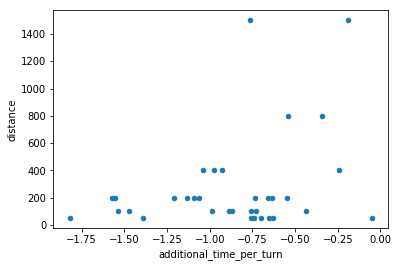

In [363]:
for i, style in view.plot.scatter(x = "additional_time_per_turn", y = "distance")